In [7]:
from pixel_cnn.model import VerticalStackConvolution, HorizontalStackConv

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random

In [9]:
def visualize_receptive_field(model, input_shape):
    """
    Visualizes the receptive field of the center pixel in the output of the model.
    Args:
        model: The convolutional model to analyze.
        input_shape: The shape of the input image (in_channels, height, width).
    """
    # Create an input image filled with zeros
    img = jnp.zeros(input_shape, dtype=jnp.float32)

    # Function to apply the model and get the output value at the center pixel
    def apply_fn(x):
        output = model(x)
        # Assuming output shape is (out_channels, height, width)
        # Sum over channels to get a scalar output
        h_center = output.shape[1] // 2
        w_center = output.shape[2] // 2
        return output[:, h_center, w_center].sum()

    # Compute gradients of the output center pixel w.r.t the input
    print(f"{img.shape=}")
    grad_fn = jax.grad(apply_fn)
    img_grads = jnp.abs(grad_fn(img))
    print(f"{img_grads.shape=}")
    img_grads = jax.device_get(img_grads)

    # Since img_grads has shape (in_channels, height, width), sum over channels
    img_grads = img_grads.sum(axis=0)  # Now shape is (height, width)
    print(f"After summing over channels: {img_grads.shape=}")

    # Plot receptive field
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pos = ax[0].imshow(img_grads, cmap='viridis')
    fig.colorbar(pos, ax=ax[0])
    ax[1].imshow(img_grads > 0, cmap='gray')

    # Mark the center pixel in red if it doesn't have any gradients
    h_center = img_grads.shape[0] // 2
    w_center = img_grads.shape[1] // 2
    show_center = (img_grads[h_center, w_center] == 0)
    if show_center:
        center_pixel = np.zeros(img_grads.shape + (4,))
        center_pixel[h_center, w_center, :] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted Receptive Field")
    ax[1].set_title("Binary Receptive Field")
    plt.show()
    plt.close()


Visualizing VerticalStackConvolution Receptive Field:
img.shape=(1, 11, 11)
img_grads.shape=(1, 11, 11)
After summing over channels: img_grads.shape=(11, 11)


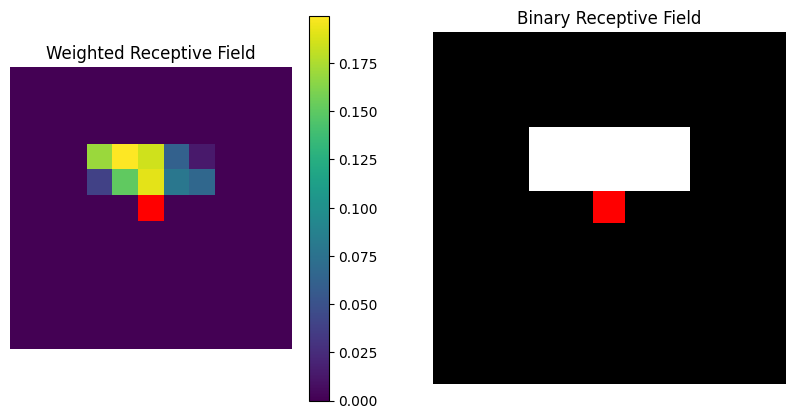

Visualizing HorizontalStackConv Receptive Field:
img.shape=(1, 11, 11)
img_grads.shape=(1, 11, 11)
After summing over channels: img_grads.shape=(11, 11)


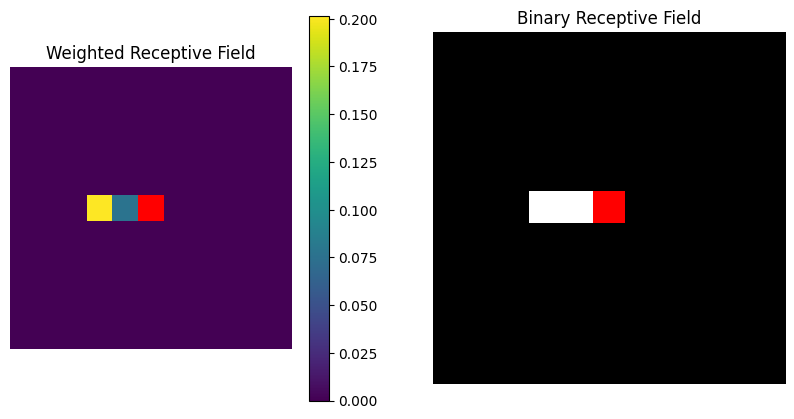

In [10]:
# Example to run the visualize_receptive_field function
# Set parameters
key = random.PRNGKey(0)
out_channels = 1  # Single output channel for simplicity
in_channels = 1  # Single input channel
kernel_size = 5
mask_center = True
dilation = 1

# Visualize VerticalStackConvolution Receptive Field
print("Visualizing VerticalStackConvolution Receptive Field:")
vertical_conv = VerticalStackConvolution(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    mask_center=mask_center,
    dilation=dilation,
    key=key
)
visualize_receptive_field(vertical_conv, input_shape=(in_channels, 11, 11))

# Visualize HorizontalStackConv Receptive Field
print("Visualizing HorizontalStackConv Receptive Field:")
horizontal_conv = HorizontalStackConv(
    in_channels=in_channels,
    out_channels=out_channels,
    kernel_size=kernel_size,
    mask_center=mask_center,
    dilation=dilation,
    key=key
)
visualize_receptive_field(horizontal_conv, input_shape=(in_channels, 11, 11))


Layer 2


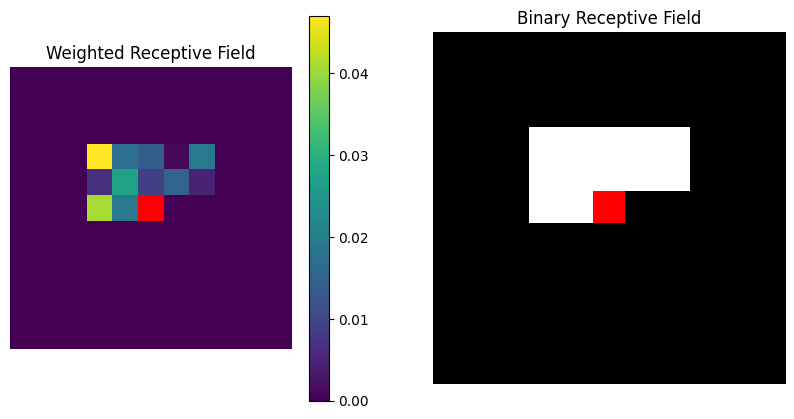

Layer 3


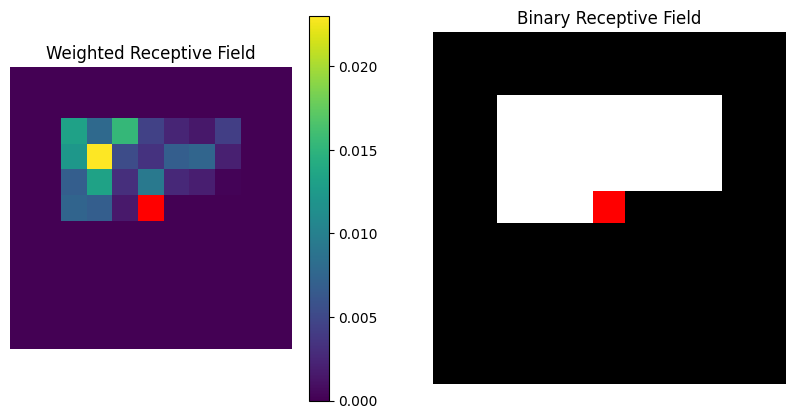

Layer 4


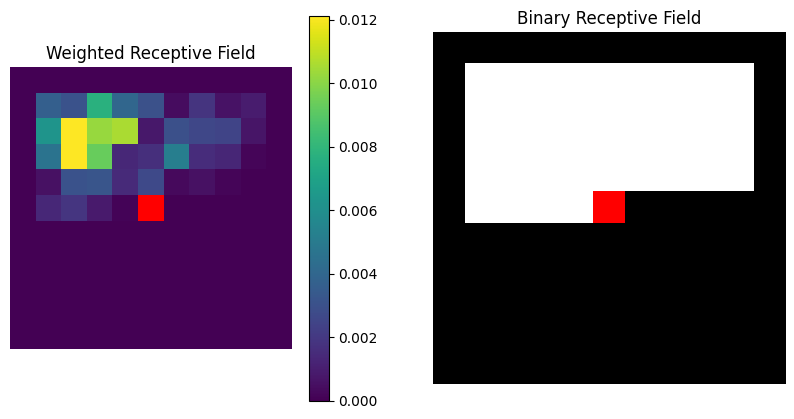

Layer 5


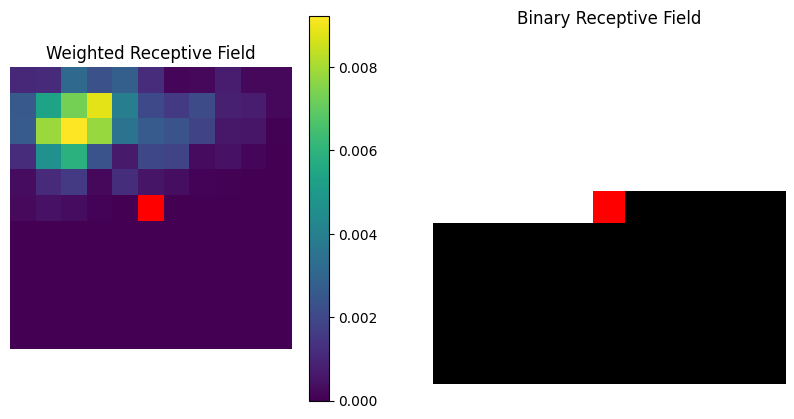

In [11]:
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt

# Initialize random keys for parameter initialization
key = random.PRNGKey(0)
key, subkey1, subkey2, subkey3, subkey4 = random.split(key, 5)

# Define the initial masked convolutions with mask_center=True
# These are used in the first layer
vert_conv = VerticalStackConvolution(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    mask_center=True,
    key=subkey1
)

horiz_conv = HorizontalStackConv(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    mask_center=True,
    key=subkey2
)

# Define the non-masked convolutions with mask_center=False
# These are reused in subsequent layers
vert_noc_conv = VerticalStackConvolution(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    mask_center=False,
    key=subkey3
)

horiz_noc_conv = HorizontalStackConv(
    in_channels=1,
    out_channels=1,
    kernel_size=3,
    mask_center=False,
    key=subkey4
)

# Define the function to build the network with multiple layers
def num_layer_network(inp, num_layers):
    # First layer with initial masked convolutions
    vert_img = vert_conv(inp)
    horiz_img = horiz_conv(inp) + vert_img
    # Subsequent layers with non-masked convolutions
    for _ in range(num_layers - 1):
        vert_img = vert_noc_conv(vert_img)
        horiz_img = horiz_noc_conv(horiz_img) + vert_img
    return horiz_img, vert_img

# Define the function to visualize the receptive field
def visualize_receptive_field(model, input_shape):
    """
    Visualizes the receptive field of the center pixel in the output of the model.
    Args:
        model: The convolutional model to analyze.
        input_shape: The shape of the input image (in_channels, height, width).
    """
    # Create an input image filled with zeros
    img = jnp.zeros(input_shape, dtype=jnp.float32)

    # Function to apply the model and get the output value at the center pixel
    def apply_fn(x):
        output = model(x)
        # Assuming output shape is (out_channels, height, width)
        # Sum over channels to get a scalar output
        h_center = output.shape[1] // 2
        w_center = output.shape[2] // 2
        return output[:, h_center, w_center].sum()

    # Compute gradients of the output center pixel w.r.t the input
    grad_fn = jax.grad(apply_fn)
    img_grads = jnp.abs(grad_fn(img))
    img_grads = jax.device_get(img_grads)

    # Since img_grads has shape (in_channels, height, width), sum over channels
    img_grads = img_grads.sum(axis=0)  # Now shape is (height, width)

    # Plot receptive field
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pos = ax[0].imshow(img_grads, cmap='viridis')
    fig.colorbar(pos, ax=ax[0])
    ax[1].imshow(img_grads > 0, cmap='gray')

    # Mark the center pixel in red if it doesn't have any gradients
    h_center = img_grads.shape[0] // 2
    w_center = img_grads.shape[1] // 2
    show_center = (img_grads[h_center, w_center] == 0)
    if show_center:
        center_pixel = np.zeros(img_grads.shape + (4,))
        center_pixel[h_center, w_center, :] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted Receptive Field")
    ax[1].set_title("Binary Receptive Field")
    plt.show()
    plt.close()

# Input image shape (in_channels, height, width)
input_shape = (1, 11, 11)
inp_img = jnp.zeros(input_shape, dtype=jnp.float32)

# Loop over different layer counts to visualize receptive field growth
for layer_count in range(2, 6):
    print(f"Layer {layer_count}")
    visualize_receptive_field(
        lambda inp: num_layer_network(inp, layer_count)[0],
        input_shape=input_shape
    )


Layer 2


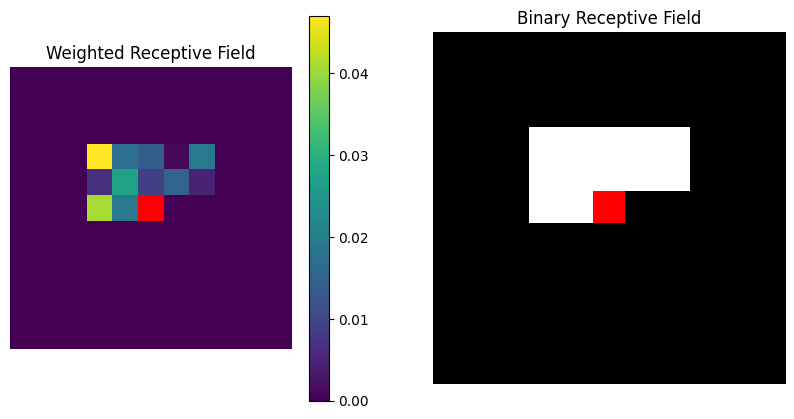

Layer 3


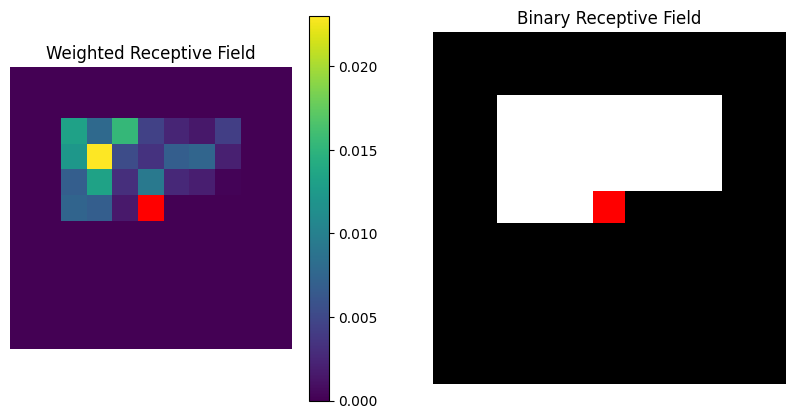

Layer 4


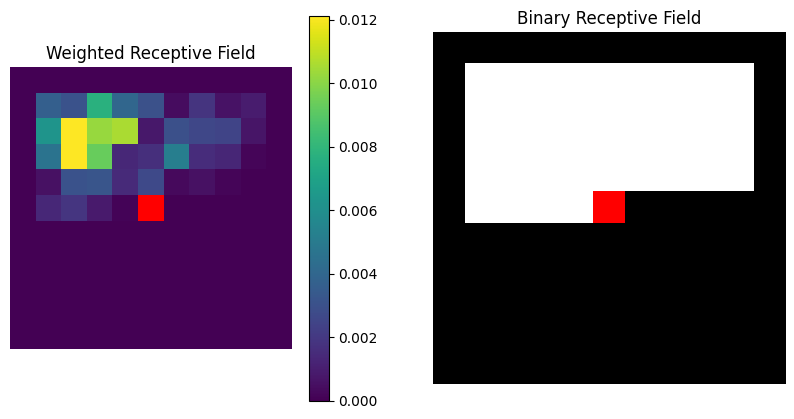

Layer 5


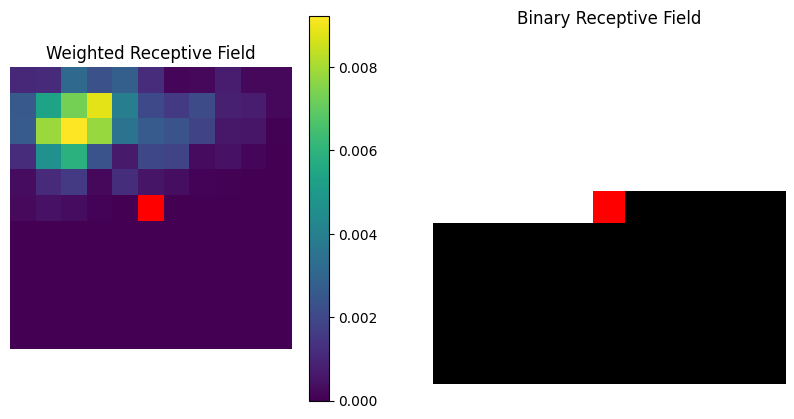

In [12]:
# Define the function to build the network with multiple layers
def num_layer_network(inp, num_layers):
    # First layer with initial masked convolutions
    vert_img = vert_conv(inp)
    horiz_img = horiz_conv(inp) + vert_img
    # Subsequent layers with non-masked convolutions
    for _ in range(num_layers - 1):
        vert_img = vert_noc_conv(vert_img)
        horiz_img = horiz_noc_conv(horiz_img) + vert_img
    return horiz_img, vert_img

# Define the function to visualize the receptive field
def visualize_receptive_field(model, input_shape):
    """
    Visualizes the receptive field of the center pixel in the output of the model.
    Args:
        model: The convolutional model to analyze.
        input_shape: The shape of the input image (in_channels, height, width).
    """
    # Create an input image filled with zeros
    img = jnp.zeros(input_shape, dtype=jnp.float32)

    # Function to apply the model and get the output value at the center pixel
    def apply_fn(x):
        output = model(x)
        # Compute the center pixel indices based on output shape
        h_center = output.shape[1] // 2
        w_center = output.shape[2] // 2
        return output[:, h_center, w_center].sum()

    # Compute gradients of the output center pixel w.r.t the input
    grad_fn = jax.grad(apply_fn)
    img_grads = jnp.abs(grad_fn(img))
    img_grads = jax.device_get(img_grads)

    # Since img_grads has shape (in_channels, height, width), sum over channels
    img_grads = img_grads.sum(axis=0)  # Now shape is (height, width)

    # Plot receptive field
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pos = ax[0].imshow(img_grads, cmap='viridis')
    fig.colorbar(pos, ax=ax[0])
    ax[1].imshow(img_grads > 0, cmap='gray')

    # Mark the center pixel in red if it doesn't have any gradients
    h_center = img_grads.shape[0] // 2
    w_center = img_grads.shape[1] // 2
    show_center = (img_grads[h_center, w_center] == 0)
    if show_center:
        center_pixel = np.zeros(img_grads.shape + (4,))
        center_pixel[h_center, w_center, :] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted Receptive Field")
    ax[1].set_title("Binary Receptive Field")
    plt.show()
    plt.close()

# Input image shape (in_channels, height, width)
input_shape = (1, 11, 11)
inp_img = jnp.zeros(input_shape, dtype=jnp.float32)

# Loop over different layer counts to visualize receptive field growth
for layer_count in range(2, 6):
    print(f"Layer {layer_count}")
    visualize_receptive_field(
        lambda inp: num_layer_network(inp, layer_count)[0],
        input_shape=input_shape
    )